# Conditional dependence
---
## From A *Priori* Dependence to Conditional Dependence
The relationships between causal structure and statistical dependence become particularly interesting and subtle when we look at the effects of additional observations or assumptions. Events that are statistically dependent a *priori* may become independent when we condition on some observation; this is called *screening off*. Also, events that are statistically independent a *priori* may become dependent when we condition on observations; this is known as *explaining away*. The dynamics of screening off and explaining away are extremely important for understanding patterns of inference—reasoning and learning—in probabilistic models.
## Screening off
*Screening off* refers to a pattern of statistical inference that is quite common in both scientific and intuitive reasoning. If the statistical dependence between two events A and B is only indirect, mediated strictly by one or more other events C, then conditioning on (observing) C should render A and B statistically independent. This can occur if A and B are connected by one or more causal chains, and all such chains run through the set of events C, or if C comprises all of the common causes of A and B.

For instance, let’s look again at our common cause example, this time assuming that we *already* know the value of C:

In [2]:
using Gen
include("auxilery.jl")

groupedviz (generic function with 6 methods)

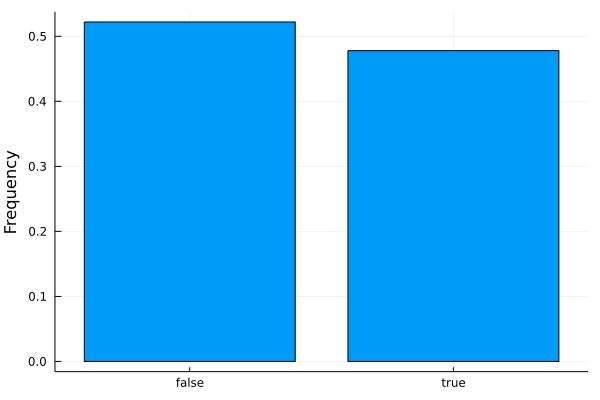

In [13]:
@gen function BcondA()
    C = @trace(bernoulli(0.5), :C)
    B = C ? @trace(bernoulli(0.5), :B) : @trace(bernoulli(0.9), :B)
    A = C ? @trace(bernoulli(0.1), :A) : @trace(bernoulli(0.4), :A)
    return B
end

ys_true = []
ys_false = []

function BcondAInfer(model,Avalue,amountOfSamples)
    observations = Gen.choicemap()
    observations[:C] = true
    observations[:A] = Avalue

    (trace, _) = Gen.importance_resampling(model, (), observations, amountOfSamples);
    return trace
end

for _ in 1:1000
    trace = BcondAInfer(BcondA  ,true, 1000)
    push!(ys_true, trace[:B])
    trace = BcondAInfer(BcondA ,false, 1000)
    push!(ys_false, trace[:B])
end

viz(ys_true)

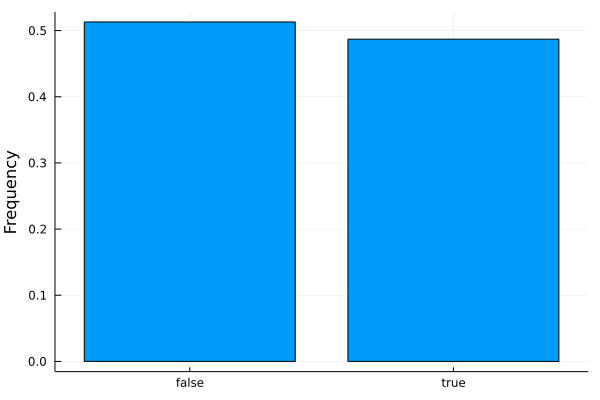

In [12]:
viz(ys_false)

We see that `A` an `B` are statistically *independent* given knowledge of `C`.

Screening off is a purely statistical phenomenon. For example, consider the the causal chain model, where A directly causes C, which in turn directly causes B. Here, when we observe C – the event that mediates an *indirect* causal relation between A and B – A and B are still causally dependent in our model of the world: it is just our beliefs about the states of A and B that become uncorrelated. There is also an analogous causal phenomenon. If we can actually manipulate or *intervene* on the causal system, and set the value of C to some known value, then A and B become both statistically and causally independent (by intervening on C, we break the causal link between A and C).

## Explaining away
“Explaining away” ([Pearl, 1988](https://scholar.google.com/scholar?q=%22Probabilistic%20reasoning%20in%20intelligent%20systems%3A%20networks%20of%20plausible%20inference%22)) refers to a complementary pattern of statistical inference which is somewhat more subtle than screening off. If two events A and B are statistically (and hence causally) independent, but they are both causes of one or more other events C, then conditioning on (observing) C can render A and B statistically dependent. Here is an example where `A` and `B` have a common *effect*:

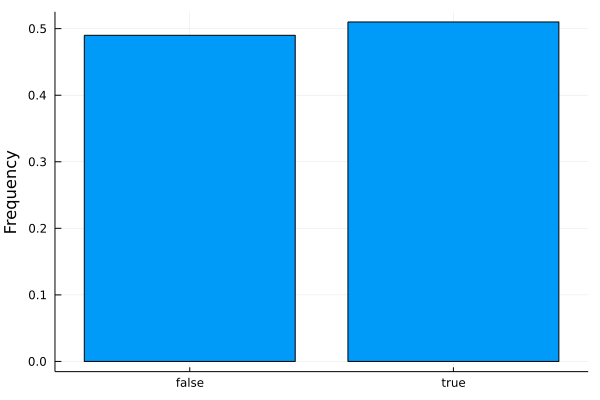

In [14]:
@gen function BcondA2()
  A = @trace(bernoulli(0.5), :A)
  B = @trace(bernoulli(0.5), :B)
  C = (A || B) ? @trace(bernoulli(0.9), :C) : @trace(bernoulli(0.2), :C)
  return B
end

ys_true = []
ys_false = []

function BcondAInfer2(model,Avalue,amountOfSamples)
  observations = Gen.choicemap()
  observations[:C] = true
  observations[:A] = Avalue

  (trace, _) = Gen.importance_resampling(model, (), observations, amountOfSamples);
  return trace
end

for _ in 1:1000
  trace = BcondAInfer2(BcondA2  ,true, 1000)
  push!(ys_true, trace[:B])
  trace = BcondAInfer2(BcondA2 ,false, 1000)
  push!(ys_false, trace[:B])
end

viz(ys_true)

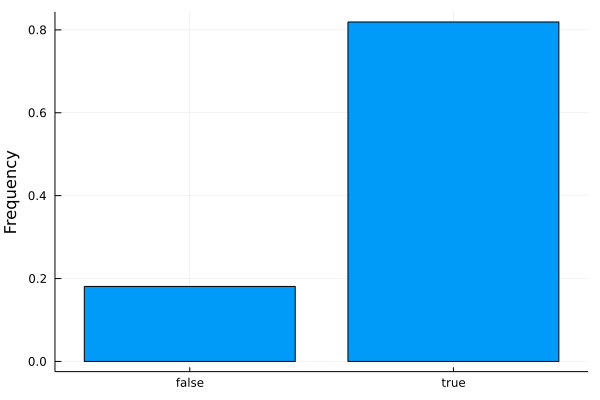

In [15]:
viz(ys_false)

As with screening off, we only induce statistical dependence from learning about `C`, not causal dependence: when we observe `C`, `A` and `B` remain causally independent in our model of the world; it is our beliefs about `A` and `B` that become correlated.

# TODO:
We can express the general phenomenon of explaining away with the following schematic Gen query:

```
Infer({...}, function() {
  var a = ...
  var b = ...
  var data = f(a, b)
  condition(data == someVal && a == someOtherVal)
  return b
})
```

We have defined two independent variables a and b both of which are used to define the value of our data. If we condition on data and a the posterior distribution on b will now be dependent on a: observing additional information about a changes our conclusions about b.

The most typical pattern of explaining away we see in causal reasoning is a kind of anti-correlation: the probabilities of two possible causes for the same effect increase when the effect is observed, but they are conditionally anti-correlated, so that observing additional evidence in favor of one cause should lower our degree of belief in the other cause. (This pattern is where the term explaining away comes from.) However, the coupling induced by conditioning on common effects depends on the nature of the interaction between the causes, it is not always an anti-correlation. Explaining away takes the form of an anti-correlation when the causes interact in a roughly disjunctive or additive form: the effect tends to happen if any cause happens; or the effect happens if the sum of some continuous influences exceeds a threshold. The following simple mathematical examples show this and other patterns.

Suppose we condition on observing the sum of two integers drawn uniformly from 0 to 9:

In [ ]:
# TODO: this code is with new viz

# var sumPosterior = Infer({method: 'enumerate'}, function() {
#   var A = randomInteger({n: 10})
#   var B = randomInteger({n: 10})
#   condition(A + B == 9);
#   return {A:A, B:B}
# })

# viz(sumPosterior)
# //sometimes this scatter plot is easier to interpret:
# viz.scatter(sumPosterior.support())

This gives perfect anti-correlation in conditional inferences for `A` and `B`. But suppose we instead condition on observing that `A` and `B` are equal:

In [ ]:
# TODO: this code is with new viz

# var sumPosterior = Infer({method: 'enumerate'}, function() {
#   var A = randomInteger({n: 10})
#   var B = randomInteger({n: 10})
#   condition(A == B)
#   return {A:A, B:B}
# })

# viz(sumPosterior)
# //sometimes this scatter plot is easier to interpret:
# viz.scatter(sumPosterior.support())

Now, of course, A and B go from being independent a priori to being perfectly correlated in the conditional distribution. Try out these other conditions to see other possible patterns of conditional dependence for *a priori* independent functions:

- `Math.abs(A - B) < 2`
- `(A + B >= 9) && (A + B <= 11)`
- `Math.abs(A - B) == 3`
- `(A - B) % 10 == 3` (Note: % means “remainder when divided by…”)
- `A % 2 == B % 2`
- `A % 5 == B % 5`

# Non-monotonic Reasoning
One reason explaining away is an important phenomenon in probabilistic inference is that it is an example of *non-monotonic* reasoning. In formal logic, a theory is said to be monotonic if adding an assumption (or formula) to the theory never reduces the set of conclusions that can be drawn. Most traditional logics (e.g. First Order) are monotonic, but human reasoning does not seem to be. For instance, if I tell you that Tweety is a bird, you conclude that he can fly; if I now tell you that Tweety is an *ostrich* you retract the conclusion that he can fly. Over the years many non-monotonic logics have been introduced to model aspects of human reasoning. One of the first reasons that probabilistic reasoning with Bayesian networks was recognized as important for AI was that it could perspicuously capture these patterns of reasoning (Pearl, 1988).

Another way to think about monotonicity is by considering the trajectory of our belief in a specific proposition, as we gain additional relevant information. In traditional logic, there are only three states of belief: true, false, and unknown (when neither a proposition nor its negation can be proven). As we learn more about the world, maintaining logical consistency requires that our belief in any proposition only move from unknown to true or false. That is our “confidence” in any conclusion only increases (and only does so in one giant leap from unknown to true or false).

In a probabilistic approach, by contrast, belief comes in a whole spectrum of degrees. We can think of confidence as a measure of how far our beliefs are from a uniform distribution—how close to the extremes of 0 or 1. In probabilistic inference, unlike in traditional logic, our confidence in a proposition can both increase and decrease. Even fairly simple probabilistic models can induce complex explaining-away dynamics that lead our degree of belief in a proposition to reverse directions multiple times as observations accumulate.


## Example: Medical Diagnosis
The medical scenario is a great model to explore screening off and explaining away. In this model `smokes` is statistically dependent on several symptoms — `cough`, `chestPain`, and `shortnessOfBreath` — due to a causal chain between them mediated by `lungDisease`. We can see this easily by conditioning on these symptoms and looking at smokes:

In [20]:
@gen function medicalDist()
    smokes = @trace(bernoulli(0.2), :smokes)
    cold = @trace(bernoulli(0.02), :cold)

    if smokes
        lungDisease = @trace(bernoulli(1 - 0.9*0.999), :lungDisease)
    else
        lungDisease = @trace(bernoulli(0.001), :lungDisease)
    end

    if cold
        fever = @trace(bernoulli(1 - 0.7*0.99), :fever)
    else
        fever = @trace(bernoulli(0.01), :fever)
    end

    if lungDisease
        chestPain = @trace(bernoulli(1 - 0.8*0.99), :chestPain)
    else
        chestPain = @trace(bernoulli(0.01), :chestPain)
    end

    if lungDisease
        shortnessOfBreath = @trace(bernoulli(1 - 0.8*0.99), :shortnessOfBreath)
    else
        shortnessOfBreath = @trace(bernoulli(0.01), :shortnessOfBreath)
    end

    if cold
        if lungDisease
            cough = @trace(bernoulli(1 - 0.5*0.5*0.999), :cough)
        else
            cough = @trace(bernoulli(1 - 0.5*0.999), :cough)
        end
    else
        if lungDisease
            cough = @trace(bernoulli(1 - 0.5*0.999), :cough)
        else
            cough = @trace(bernoulli(0.001), :cough)
        end
    end
    
    return smokes
end

ys = []

function medicalDistInfer(model, amountOfSamples)
  observations = Gen.choicemap()
  observations[:cough] = true
  observations[:chestPain] = true
  observations[:shortnessOfBreath] = true

  (trace, _) = Gen.importance_resampling(model, (), observations, amountOfSamples);
  return trace
end

for _ in 1:1000
  trace = medicalDistInfer(medicalDist, 1000)
  push!(ys, trace[:smokes])
end

viz(ys)

The conditional probability of smokes is much higher than the base rate, 0.2, because observing all these symptoms gives strong evidence for smoking. See how much evidence the different symptoms contribute by dropping them out of the conditioning set. (For instance, try conditioning on cough && chestPain, or just cough; you should observe the probability of smokes decrease as fewer symptoms are observed.)

Now, suppose we condition also on knowledge about the function that mediates these causal links: lungDisease. Is there still an informational dependence between these various symptoms and smokes? In the Inference below, try adding and removing various symptoms (cough, chestPain, shortnessOfBreath) but maintaining the observation lungDisease:
